<a href="https://colab.research.google.com/github/RainXie23/MANE4961---Machine-Learning-for-Engineering-Fall-2025-/blob/main/HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Construct a fully connected neural network model for classifying the CIFAR-10
dataset. Use a 70%-30% split for training and validation data.
(a) (10 pts.) Visualize the data by plotting an image from each category from the
CIFAR-10 dataset.
(b) (30 pts.) Demonstrate the tuning of the hyperparameters of the neural network
via grid-search.
(c) (5 pts.) Calculate and plot the training and validation losses of the tuned network.
(d) (5 pts.) Calculate and plot the training and validation accuracies of the tuned
network.

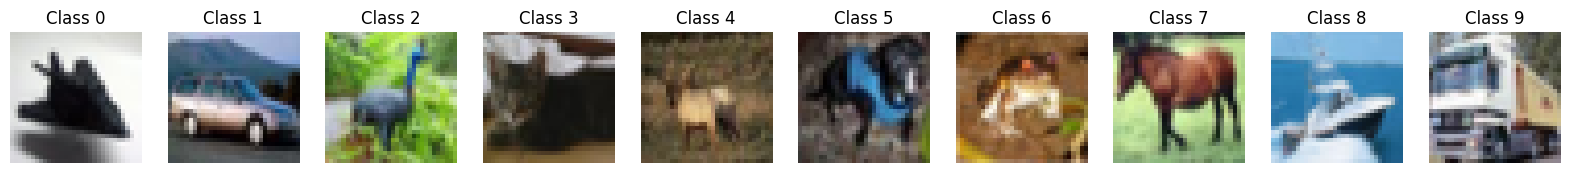

In [20]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

found_classes = set()
fig, axes = plt.subplots(1, 10, figsize=(20, 2)) # Create a figure and subplots

for i, (image, label) in enumerate(trainset):
    if label not in found_classes:
        axes[label].imshow(image.permute(1, 2, 0)) # CIFAR-10 images are in CxHxW format, imshow expects HxWx3
        axes[label].set_title(f'Class {label}')
        axes[label].axis('off') # Hide axes
        found_classes.add(label)
    if len(found_classes) == 10:
        break

plt.show()

In [21]:
train_size = int(0.7 * len(trainset))
val_size = len(trainset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(trainset, [train_size, val_size])

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Training dataset size: 35000
Validation dataset size: 15000


In [22]:
!pip install skorch

In [23]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 128)  # CIFAR-10 images are 3x32x32
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32) # Flatten the image
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [24]:
from skorch import NeuralNetClassifier

net = NeuralNetClassifier(
    SimpleNN,
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    verbose=0,  # Suppress verbose output during grid search
)

In [25]:
from sklearn.model_selection import GridSearchCV
import numpy as np

# Define the hyperparameter grid
param_grid = {
    'lr': [0.001, 0.01],
    'max_epochs': [10, 20],
}

In [27]:
# Perform grid search
# Convert CIFAR-10 dataset to numpy arrays for scikit-learn compatibility
X_train = train_dataset.dataset.data[train_dataset.indices].transpose((0, 3, 1, 2)).astype(np.float32) / 255.0
y_train = np.array(train_dataset.dataset.targets)[train_dataset.indices]

grid_search = GridSearchCV(net, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: ", grid_search.best_score_)

Best parameters found:  {'lr': 0.001, 'max_epochs': 20}
Best accuracy found:  0.4365140007045328


In [28]:
# Get the best parameters from the grid search
best_params = grid_search.best_params_
best_epochs = best_params['max_epochs']
best_lr = best_params['lr']

# Train the model with the best parameters
best_model = NeuralNetClassifier(
    SimpleNN,
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    optimizer__lr=best_lr,
    max_epochs=best_epochs,
    verbose=1, # Set verbose to 1 to see training progress
)

# Convert the datasets to the format expected by skorch
import numpy as np
X_train_skorch = train_dataset.dataset.data[train_dataset.indices].transpose((0, 3, 1, 2)).astype(np.float32) / 255.0
y_train_skorch = np.array(train_dataset.dataset.targets)[train_dataset.indices]

# Fit the best model
history_skorch = best_model.fit(X_train_skorch, y_train_skorch)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.9931       0.3517        1.8332  0.8630
      2        1.8197       0.3569        1.7674  0.8137
      3        1.7371       0.3670        1.7538  0.8505
      4        1.6943       0.3904        1.7057  1.1012
      5        1.6539       0.4119        1.6539  1.0776
      6        1.6213       0.4203        1.6265  1.1331
      7        1.5908       0.4250        1.6070  1.3071
      8        1.5658       0.4320        1.5962  1.0692
      9        1.5406       0.4347        1.5852  1.0924
     10        1.5191       0.4399        1.5742  1.0597
     11        1.4947       0.4467        1.5598  1.0695
     12        1.4754       0.4497        1.5530  1.0787
     13        1.4553       0.4509        1.5513  1.0581
     14        1.4383       0.4571        1.5368  1.0576
     15        1.4227       0.4587        1.5322  1.0658
     16        1.4071       0.4

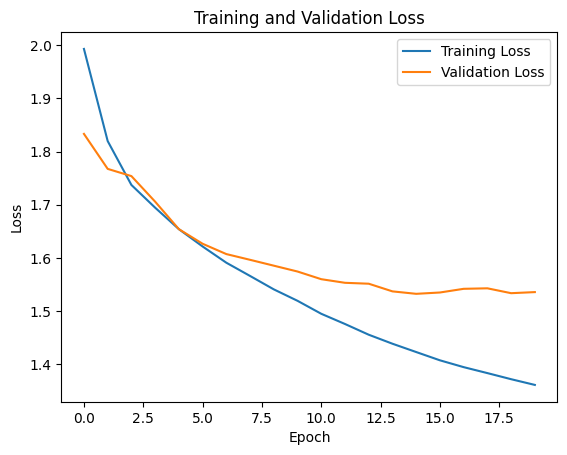

In [29]:
import matplotlib.pyplot as plt

# Access the history from the skorch model
train_losses = history_skorch.history[:, 'train_loss']
val_losses = history_skorch.history[:, 'valid_loss']

# Plot
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

2) Obtain the NASA airfoil self-noise dataset from UCI machine learning dataset repository.
The dataset describes different size NACA 0012 airfoils at various wind tunnel speeds
and angles of attack. The span of the airfoil and the observer position were the same in
all of the experiments. The following attributes were measured:
i. Frequency, in Hz.
ii. Angle of attack, in degrees.
iii. Chord length, in meters.
iv. Free-stream velocity, in meters per second.
v. Suction side displacement thickness, in meters.
The only measured output was:
i. Scaled sound pressure level, in decibels.
(a) (10 pts.) Visualize the dataset.
(b) (30 pts.) Construct a fully connected neural network model for estimating
scaled sound pressure level, in decibels, from the attributes by choosing a 70%-30%
split.
(c) (10 pts.) Calculate the coefficient of determination.

In [2]:
import pandas as pd
import numpy as np

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00291/airfoil_self_noise.dat'

df = pd.read_csv(url,
                 sep='\t',      # tab-separated
                 header=None)   # no headers

df.columns = ['Frequency', 'Angle_of_Attack', 'Chord_Length', 'Velocity', 'Displacement_Thickness', 'Sound_Pressure']

<function matplotlib.pyplot.show(close=None, block=None)>

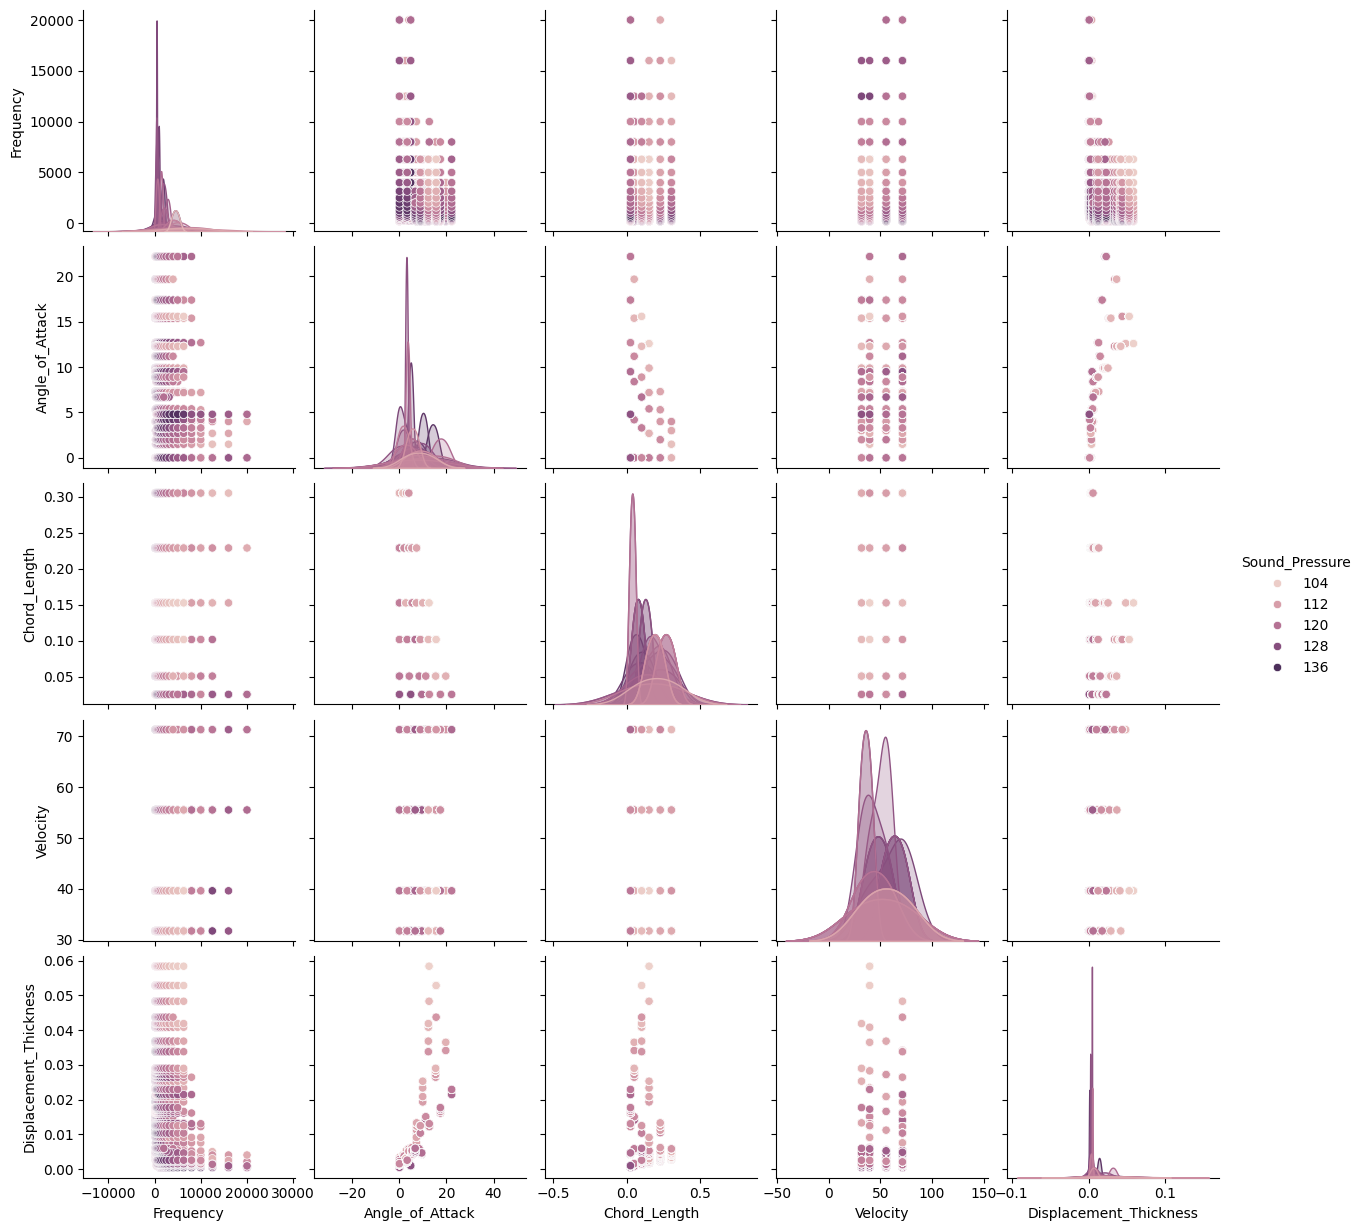

In [3]:
import seaborn as sns

sns.pairplot(df, hue = 'Sound_Pressure')
plt.show

In [4]:
import keras
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Separate features (X) and target (y)
X = df.drop('Sound_Pressure', axis=1)
y = df['Sound_Pressure']

# Split the data into training and testing sets (70%-30% split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Shape of X_train_scaled:", X_train.shape)
print("Shape of X_test_scaled:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train_scaled: (1052, 5)
Shape of X_test_scaled: (451, 5)
Shape of y_train: (1052,)
Shape of y_test: (451,)


In [11]:
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

# Define the model-building function
def build_model(optimizer='adam', learning_rate=0.001):
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)  # No activation for regression
    ])
    optimizer_instance = keras.optimizers.get(optimizer)
    model.compile(optimizer=optimizer_instance, loss='mean_squared_error')
    return model

# Wrap the model with KerasRegressor
keras_regressor = KerasRegressor(model=build_model, verbose=0) # Set verbose to 0 to avoid excessive output

# Define the hyperparameter grid
param_grid = {
    'model__learning_rate': [0.001, 0.01],
    'epochs': [10, 20],
    'batch_size': [16, 32]
}

# Perform grid search
grid = GridSearchCV(estimator=keras_regressor,
                    param_grid=param_grid,
                    cv=3,  # 3-fold cross-validation
                    scoring='neg_mean_squared_error')

grid_result = grid.fit(X_train, y_train)

print("Best parameters found: ", grid_result.best_params_)
print("Best negative mean squared error found: ", grid_result.best_score_)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

Best parameters found:  {'batch_size': 16, 'epochs': 20, 'model__learning_rate': 0.01}
Best negative mean squared error found:  -144.29632511695954


In [17]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)  # No activation for regression
])

model.compile(optimizer='adam',
              loss='mse' )

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=16)

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 15313.3350 - val_loss: 13879.3428
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12879.3994 - val_loss: 8623.8682
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6839.0776 - val_loss: 2085.0203
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1447.4561 - val_loss: 477.6302
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 502.3578 - val_loss: 369.3487
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 386.4477 - val_loss: 325.2047
Epoch 7/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 332.6928 - val_loss: 284.5617
Epoch 8/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 295.4565 - val_loss: 255.3563
Epoch 9/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 239.5990 - val_loss: 222.6434
Epoch 10/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 225.7136 - val_loss: 194.2062
Epoch 11/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 202.5027 - val_loss: 172.1871
Epoch 12/20
66/66 ━━━━━━━━━━━━

In [18]:
from sklearn.metrics import r2_score

# After training your model, make predictions
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_test)

# Calculate R²
r2_train = r2_score(y_train, y_train_pred)
r2_val = r2_score(y_test, y_val_pred)

print(f"Training R²: {r2_train}")
print(f"Validation R²: {r2_val}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Training R²: -0.2896951313195715
Validation R²: -0.3775583125923927
